# Optimisation & Simulation: Lab on MCMC methods

**Objective:**
- Use Markov chain Monte Carlo (MCMC) methods to draw from complex distributions.

**Implementation:**
- Gibbs sampling
- Metropolis-Hastings algorithm

**Agenda:**
1. Implement Gibbs sampler to generate draws from bivariate normal.
2. Implement Metropolis-Hastings algorithms to infer posterior distribution of parameters of Cauchy distribution. 

## Gibbs sampling

### Background

**Motivation and intuition:**
- Draw from multivariate distributions from which direct sampling is difficult.
- Construct conditional distributions from which sampling is easy. 
- Iteratively draw from conditional distributions. 


- Suppose we wish to sample $\theta_{1}, \theta_{2} \sim p(\theta_{1}, \theta_{2})$ but cannot do so directly. 
- However, we can sample $\theta_{1} \sim p(\theta_{1} \vert \theta_{2})$ and $\theta_{2} \sim p(\theta_{2} \vert \theta_{1})$.

**Algorithm:**
1. Set $j = 0$. 
2. Provide initial values $(\theta_{1}^{(0)}, \theta_{2}^{(0)})$. 
3. Set $j = j + 1$. 
4. $\theta_{1}^{(j)} \sim p(\theta_{1}^{(j)} \vert \theta_{2}^{(j-1)})$.
5. $\theta_{2}^{(j)} \sim p(\theta_{2}^{(j)} \vert \theta_{1}^{(j)})$.
6. If $j$ is less than the desired number of draws, return to step 3.

### Exercise
- Implement a Gibbs sampler to draw from a bivariate normal, i.e. 
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} (\boldsymbol{\mu}, \boldsymbol{\Sigma})
\text{ with }
\boldsymbol{\mu} = \boldsymbol{0},
\boldsymbol{\Sigma} = 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix},
\rho = 0.8
$$
- Visually compare the empirical density of the draws to the theoretical density of the sampling distribution. 

**Note:**
- If
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} \left (\boldsymbol{0}, 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix}
\right ),
$$
then 
$$
\theta_{1} \vert \theta_{2} \sim \mathcal{N}(\rho \theta_{2}, 1 - \rho^{2}),
$$
$$
\theta_{2} \vert \theta_{1} \sim \mathcal{N}(\rho \theta_{1}, 1 - \rho^{2}).
$$

#### Implementation

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [30]:
def gibbs(rho, theta2, n_draws):
    """ Gibbs sampling of bivariate normal.
    
    Keywords:
        rho (float): correlation parameter.
        theta2 (float): initial value of theta2.
        n_draws (int): number of draws.
    
    Returns:
        theta (array): draws from bivariate normal.
    """
    
    theta = np.zeros([2, n_draws+1])
    theta[1][0] = theta2
    #theta[0][0] = np.random.normal(rho*theta[1][0], np.sqrt(1-rho**2))
    for i in range(n_draws):
        theta[0][i+1] = np.random.normal(rho*theta[1][i], np.sqrt(1-rho**2))
        theta[1][i+1] = np.random.normal(rho*theta[0][i+1], np.sqrt(1-rho**2)) 
    theta = theta[:, 1:] # Drop initial guess
    return theta

In [31]:
rho = 0.8
theta2 = 0
n_draws = 1000

draws = gibbs(rho, theta2, n_draws)

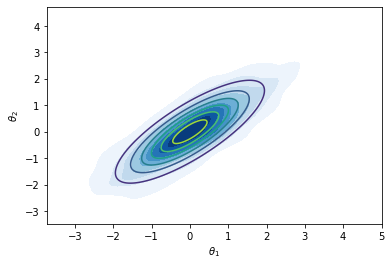

In [32]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

#Theoretical density
mu = np.array([0, 0])
Sigma = np.array([[1, rho], [rho, 1]])
x = np.arange(-3,3,0.01)
xx, yy = np.meshgrid(x,x)
z = multivariate_normal.pdf(np.stack((xx, yy), axis=2), mu, Sigma)
ax.contour(x, x, z)

#Empirical draws
ax = sns.kdeplot(
    draws[0,:], y=draws[1,:],
    cmap= "Blues" , shade = True
)

ax.set(
    xlabel=r'$\theta_1$',
    ylabel=r'$\theta_2$'
)

plt.show()

## Metropolis-Hastings algorithm

### Background

**Motivation and intuition:**
- Gibbs sampling is only feasible, if the conditional distributions are known and if it is easy to sample from them. 
- The Metropolis-Hastings algorithm allows us to sample from any density $p(\theta)$, provided that we can evaluate $f(\theta)$, a density that is proportional to $p$. 
- At each iteration, we sample a new state from a candidate distribution, which depends on the current state. 
- With some probability depending on the value of the target density at the new and the current states, the new state is accepted. 
- As the algorithm proceeds, the sampled states approximate the desired density. 

**Algorithm:**
1. Set $j = 0$.
2. Let $\theta$ denote the current state.
3. Let $p(\theta \vert x)$ denote the target density.
4. Let $J(\theta^{*} \vert \theta)$ denote the jumping distribution
5. Let $\rho$ denote the step size.
6. Set $j = j + 1$. 
7. Propose a new state $\theta^{*} \vert \theta \sim J(\theta)$.
8. Calculate $\alpha = \frac{p(\theta^{*} \vert x)}{p(\theta \vert x)} \cdot \frac{J(\theta \vert \theta^{*})}{J(\theta^{*} \vert \theta)}$.
9. Draw $r \sim \text{Uniform}(0,1)$.
10. If $r \leq \alpha$, accept the new state and set $\theta = \theta^{*}$. Otherwise, reject the new state. 
11. If $j$ is less than the desired number of draws, return to step 5.

### Exercise 
- Simulate data from Cauchy distribution with location $\mu = 1$ and scale $\gamma = 1$.
- Implement a Metroplis-Hastings algorithms to infer the posterior distribution of the scale parameter of the Cauchy distribution.
- Consider two possible jumping distributions:
- 1. $\text{Normal}(\theta, \rho^2)$, where $\rho$ is the step size.
- 2. $\text{Lognormal}(\theta - 0.5 \rho^2, \rho^2)$, where $\rho$ is a distance parameter.
- Evaluate the performance of the algorithms for different parametrisations of the jumping distributions. Compute the potential scale reduction factors $\hat{R}$ and the effective sample size $n_{\text{eff}}$.

Suppose
- $x_{i} \sim \mathcal{C}(\mu, \gamma)$ for $i \in \{1, \dots, N\}$
- $\gamma \sim \text{Gamma}(\alpha_{0}, \beta_{0})$ with $\alpha_{0} = \beta_{0} = 0.001$.

Then
$$
p(\gamma \vert x, \mu, \alpha_{0}, \beta_{0}) 
\propto \left ( \prod_{i} p(x_{i} \vert \mu, \gamma) \right ) p(\gamma \vert \alpha_{0}, \beta_{0})
$$

**Note:**
- PDF of Cauchy distribution:
$$
f(x \vert \mu, \gamma) = \frac{1}{\pi \gamma \left [ 1 + \left (\frac{x - \mu}{\gamma} \right )^{2} \right ]}
$$
- Quantile function of Cauchy distribution:
$$
Q = \mu + \gamma \cdot \text{tan}\left [ \pi \left ( F - \frac{1}{2} \right ) \right ]
$$

#### Cauchy random draws

In [33]:
def cauchy_rng(mu, gamma, n_draws):
    """ Generate cauchy random numbers.
    
    Keywords:
        mu (float): location parameter.
        gamma (float): scale parameter.
        n_draws (int): number of draws.
    
    Returns:
        r (array): n_draws draws from Cauchy(mu, gamma).
    """
    u = np.random.rand(n_draws,)
    r = mu + gamma * np.tan(np.pi * (u - 0.5))
    return r

In [34]:
def evaluate_log_cauchy_pdf(x, mu, gamma):
    value = -np.log(np.pi*gamma) - np.log(1+((x-mu)/gamma)**2)
    #value = 1/(np.pi*gamma*(1+((x-mu)/gamma)**2))
    #print(value)
    return value

In [35]:
mu = 1
gamma_true = 1
n_draws = 1000
x = cauchy_rng(mu, gamma_true, n_draws)

#### Normal jumping distribution
##### Implementation

In [36]:
def rhat_n_eff(draws):
    """ Computes potential scale reduction factor and effective sample size.
    
    Keywords:
        draws (1d-array): draws
    
    Returns:
        R (float): potential scale reduction factor.
        n_eff (float): effective sample size.
    """
    #Reshape draws
    psi_cd = np.array(draws).reshape(2,-1)
    C, D = psi_cd.shape
    
    #Rhat
    psi_c = psi_cd.mean(axis=1, keepdims=True)
    psi = psi_c.mean()
    B = D / (C - 1) * np.sum((psi_c - psi)**2) #Between-chain variance
    s2_c = 1 / (D - 1) * np.sum((psi_cd - psi_c)**2, axis=1)
    W = s2_c.mean() #Within-chain variance
    var = (D - 1) / D * W + 1 / D * B
    R = np.sqrt(var / W)
    
    #Effective sample size
    V = lambda t: ((psi_cd[:,t:] - psi_cd[:,:(D-t)])**2).sum() / (C * (D - t)) #Variogram
    negative_autocorr = False
    t = 1
    rho = np.ones(D)
    while not negative_autocorr and (t < D):
        rho[t] = 1 - V(t) / (2 * var)
        if not t % 2:
            negative_autocorr = np.sum(rho[t-1:t+1]) < 0
        t += 1
    n_eff = C * D / (1 + 2 * np.sum(rho[1:t]))
    
    return R, n_eff

In [37]:
def mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with normal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_store (array): accept flags.
    """
    j = 0
    k = 0
    gamma_store = np.zeros((n_keep,))
    accept_store = np.zeros((n_keep,), dtype='bool')
    theta = gamma
    while j < (n_burn + n_keep):
        candidate = np.random.normal(theta, rho)
        if candidate < 0:
            print('negative')
        else:
            alpha = 0
            for i in range(np.size(x)): # The ratio between Js will be 1
                alpha = alpha + evaluate_log_cauchy_pdf(x[i], mu, candidate) - evaluate_log_cauchy_pdf(x[i], mu, theta)
            alpha = alpha + evaluate_log_cauchy_pdf(candidate, alpha0, beta0) - evaluate_log_cauchy_pdf(theta, alpha0, beta0)
            r = np.random.rand()
            if np.log(r) <= alpha:
                theta = candidate
            if j > n_burn:
                gamma_store[k] = theta
                accept_store[k] = (theta == candidate)
                k += 1
        j += 1
        
    return gamma_store, accept_store     

In [38]:
mu = 1
gamma = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000

gamma_store, accept_store = mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)

negative
negative
negative


In [39]:
gamma_store.mean()

0.9752859159322739

In [40]:
gamma_store.std()

0.053972023358857715

In [41]:
accept_store.mean()

0.449

In [42]:
rhat_n_eff(gamma_store)

(1.0017594714359523, 37.937580873868136)

In [43]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
n

In [44]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,0.100880,0.003194,0.966,0.999182,6.548542
1,0.00010,0.132886,0.007470,0.851,1.720541,1.976453
2,0.00100,0.521237,0.052715,0.847,2.010794,1.751928
3,0.01000,0.973398,0.046661,0.952,1.012639,11.063706
4,0.10000,0.978977,0.056019,0.477,1.005905,17.504608
5,0.25000,0.971803,0.055861,0.229,1.001254,29.146511
6,0.50000,0.928968,0.216021,0.119,1.046251,5.819857
7,1.00000,0.821898,0.351974,0.042,1.174160,4.382357


##### Trace plot

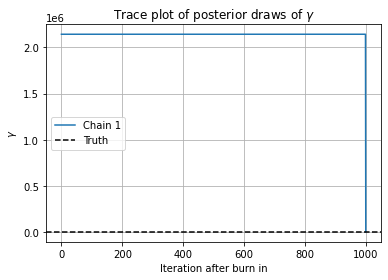

In [57]:
fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()

#### Lognormal jumping distribution
##### Implementation

In [46]:
def lognormal_j(theta, mu, rho):
    log_j = -np.log(theta)-(np.log(theta)-mu)**2/2/rho**2
    return log_j

In [58]:
def mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with lognormal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_store (array): accept flags.
    """
    
    j = 0
    k = 0
    gamma_store = np.zeros((n_keep,))
    accept_store = np.zeros((n_keep,), dtype='bool')
    theta = gamma
    while j < (n_burn + n_keep):
        candidate = np.random.lognormal(theta - 0.5*(rho**2), rho)
        if candidate < 0:
            print('negative')
        else:
            alpha = 0
            for i in range(np.size(x)):
                alpha = alpha + evaluate_log_cauchy_pdf(x[i], mu, candidate) - evaluate_log_cauchy_pdf(x[i], mu, theta)
            alpha = alpha+ lognormal_j(theta,np.log(candidate)-0.5*rho**2,rho)-lognormal_j(candidate, np.log(theta)-0.5*rho**2,rho)
            alpha = alpha + evaluate_log_cauchy_pdf(candidate, alpha0, beta0) - evaluate_log_cauchy_pdf(theta, alpha0, beta0)
            r = np.random.rand()
            if np.log(r) <= alpha:
                theta = candidate
            if j > n_burn:
                gamma_store[k] = theta
                accept_store[k] = (theta == candidate)
                k += 1
        j += 1
            
    return gamma_store, accept_store    

In [59]:
mu = 1
gamma = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000

gamma_store, accept_store = mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)

In [60]:
gamma_store.mean()

1.2019294214018745

In [61]:
gamma_store.std()

0.03802736402179213

In [62]:
accept_store.mean()

0.0

In [63]:
rhat_n_eff(gamma_store)

(0.9999999999999999, 6.4976519718259285)

In [66]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

In [67]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,1.104080,0.034932,0.000,1.000000,6.497652
1,0.00010,1.104187,0.034935,0.000,1.000000,6.497652
2,0.00100,1.104647,0.034949,0.000,1.000000,6.497652
3,0.01000,1.109071,0.035089,0.000,1.000000,6.497652
4,0.10000,1.111521,0.035167,0.000,1.000000,6.497652
5,0.25000,1.144481,0.036210,0.000,1.000000,6.497652
6,0.50000,0.998848,0.059015,0.027,0.999822,14.082357
7,1.00000,0.979612,0.047227,0.050,1.005201,10.275830


##### Trace plot

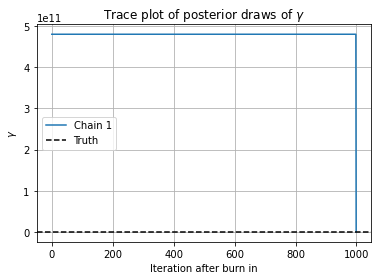

In [55]:
fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[0.1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()